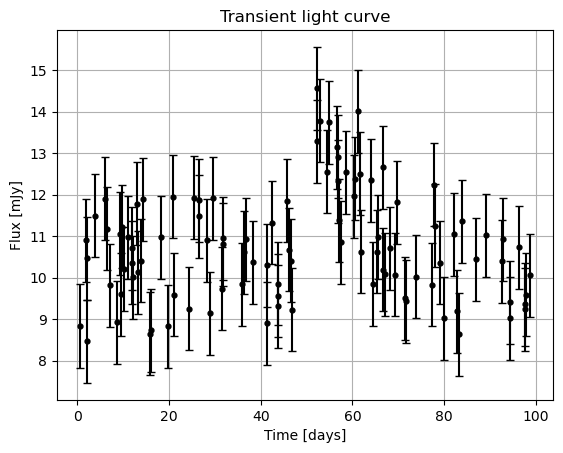

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import dynesty 
import scipy.stats


data = np.load('transient.npy', allow_pickle=True)
time = data[:,0]
flux = data[:,1]
sigma = data[:,2]
fig1, ax1 = plt.subplots()
ax1.set_xlabel("Time [days]")
ax1.set_ylabel("Flux [mJy]")
ax1.set_title("Transient light curve")
ax1.errorbar(time, flux, yerr=sigma, fmt='.k', markersize=7, capsize= 3, zorder = 2)
ax1.grid()


In [13]:
ndim = 4 # Number of parameters: b, t0, A, c
labels_burst = ['b', r't$_0$', 'A', 'c']
labels_gauss = ['b', r't$_0$', 'A', r'$\sigma_w$']

def model_burst(params, t):
    b, t0, A, c = params
    exponent = -c*(t - t0)
    exponent = np.clip(exponent, -100, 100)  # Prevent overflow
    f = A * np.exp(exponent)  
    return np.where(t < t0, b, b + f) 

def model_gauss(params, t):
    b, t0, A, sigmaw = params
    exponent = -0.5*((t - t0)/sigmaw)**2
    exponent = np.clip(exponent, -100, 100)  # Prevent overflow
    return b + A * np.exp(exponent)

def LogLikelihood (params, t, y, sigmay, model):
    flux_model = model(params, time)
    return -0.5*(len(t)*np.log(2*np.pi) + np.sum(2*np.log(sigmay) + ((y-flux_model)/sigmay)**2))

def Prior_burst (u):
    x_b = np.array(u) 
    x_b[0] = scipy.stats.uniform(loc=9,scale=2).ppf(u[0])
    x_b[1] = scipy.stats.uniform(loc=45, scale=10).ppf(u[1])
    x_b[2] = scipy.stats.uniform(loc=0, scale=15).ppf(u[2])
    x_b[3] = scipy.stats.loguniform.ppf(u[3], np.exp(-3), np.exp(-1.20))
    return x_b

def Prior_gauss (u):
    x_g = np.array(u) 
    x_g[0] = scipy.stats.uniform(loc=9,scale=2).ppf(u[0])
    x_g[1] = scipy.stats.uniform(loc=48, scale=15).ppf(u[1])
    x_g[2] = scipy.stats.uniform(loc=0, scale=10).ppf(u[2])
    x_g[3] = scipy.stats.loguniform.ppf(u[3], np.exp(0), np.exp(3))
    return x_g

In [14]:
sampler_burst = dynesty.NestedSampler(LogLikelihood, Prior_burst, ndim, logl_args=[time, flux, sigma, model_burst], nlive=300, sample='unif')
sampler_burst.run_nested()
results_burst = sampler_burst.results

2252it [02:32, 14.78it/s, +300 | bound: 17 | nc: 1 | ncall: 18368 | eff(%): 14.124 | loglstar:   -inf < -140.655 <    inf | logz: -146.891 +/-  0.133 | dlogz:  0.001 >  0.309]


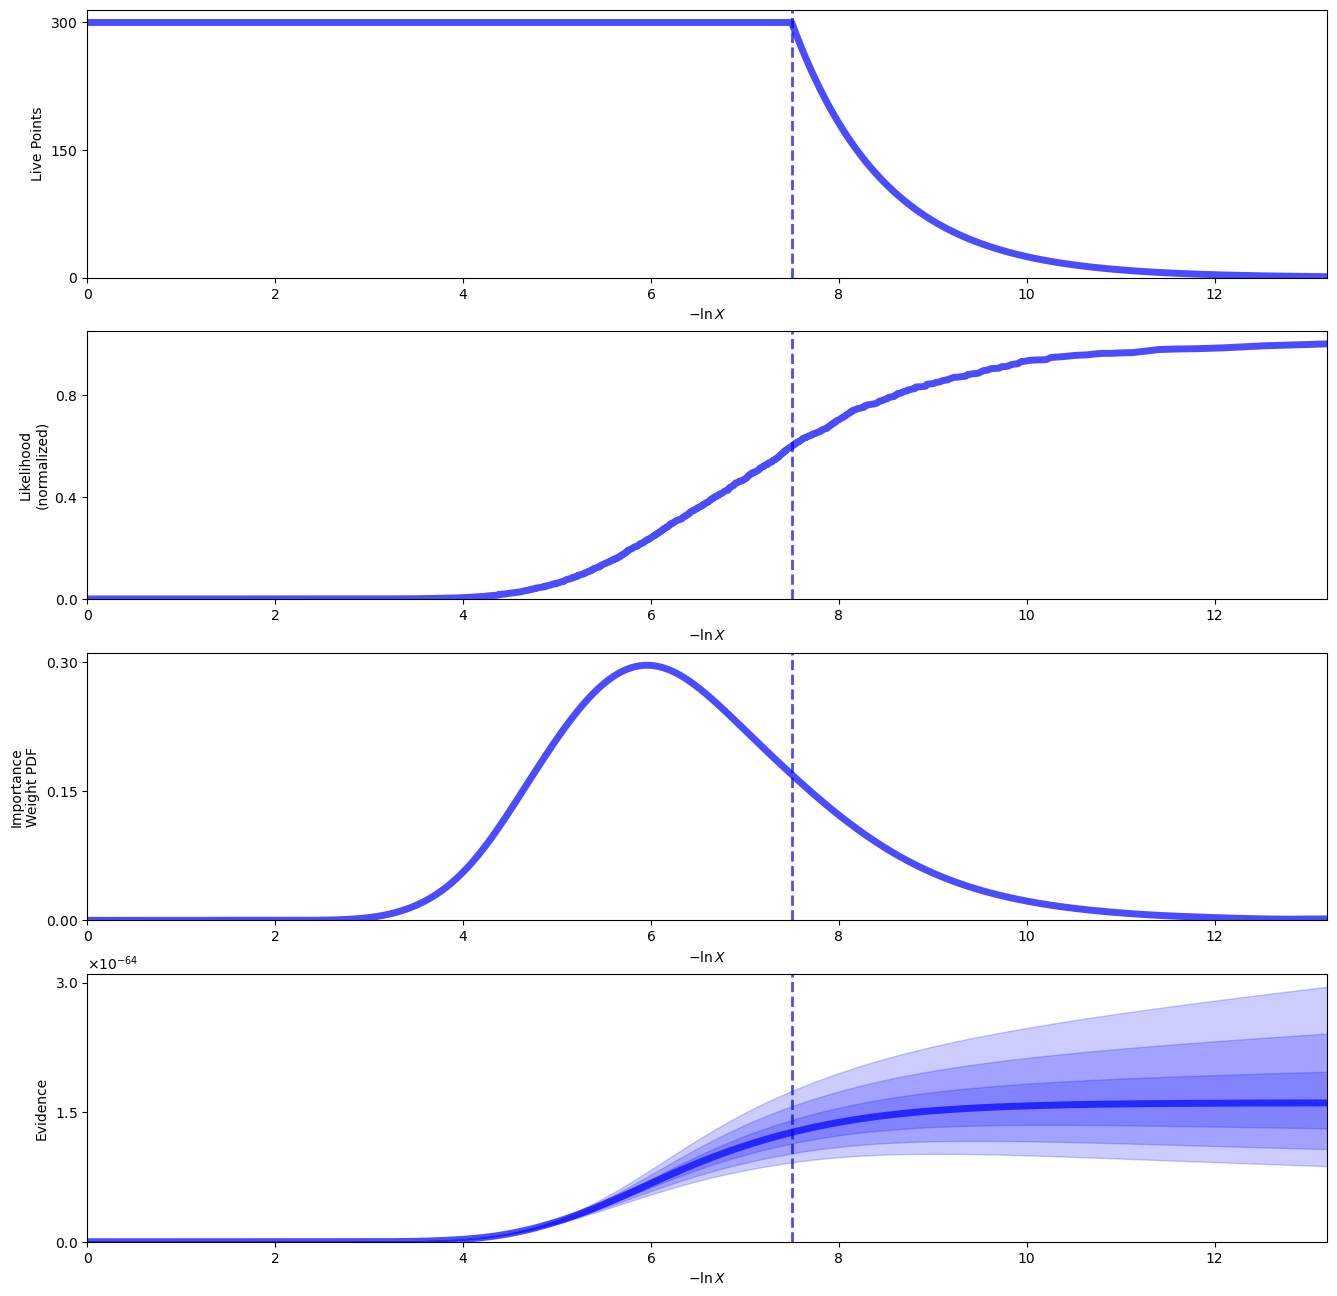

In [15]:
from dynesty import plotting as dyplot
fig2, ax2 = dyplot.runplot(results_burst)

In [16]:
from dynesty import utils as dyfunc
from dynesty.utils import resample_equal


# Extract sampling results.
samples_burst = results_burst.samples  # samples
weights_burst = np.exp(results_burst.logwt - results_burst.logz[-1])  # normalized weights

means_burst, cov_burst = dyfunc.mean_and_cov(samples_burst, weights_burst)
print("Mean parameters and covariance for burst model", means_burst, cov_burst.diagonal())

dw = resample_equal(samples_burst, weights_burst)
medians_burst = np.median(dw, axis=0)
print("Median parameters by resample for burst model", medians_burst)

medians_burst = np.squeeze(np.array([dyfunc.quantile(x, [0.5], weights=weights_burst) for x in samples_burst.T]))
print("Weighted medians for burst model", medians_burst)


Mean parameters and covariance for burst model [10.29296021 49.2481876   5.73915905  0.1266424 ] [1.47197837e-02 2.31457007e+00 2.65845617e+00 7.85805211e-04]
Median parameters by resample for burst model [10.2929886  49.10786809  5.46619443  0.1247233 ]
Weighted medians for burst model [10.29297477 49.112773    5.46321611  0.12454583]


Text(0.5, 1, 'Corner plot of the posterior distributions')

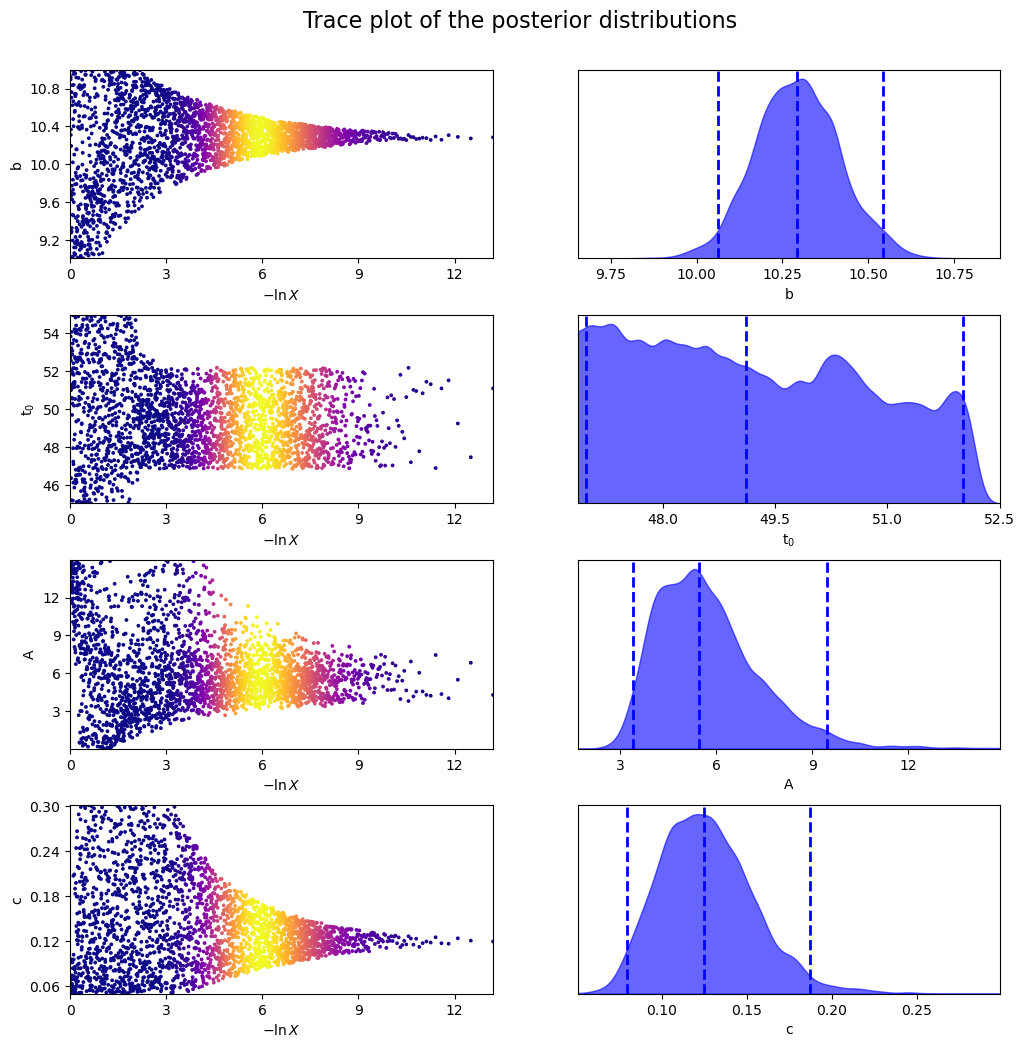

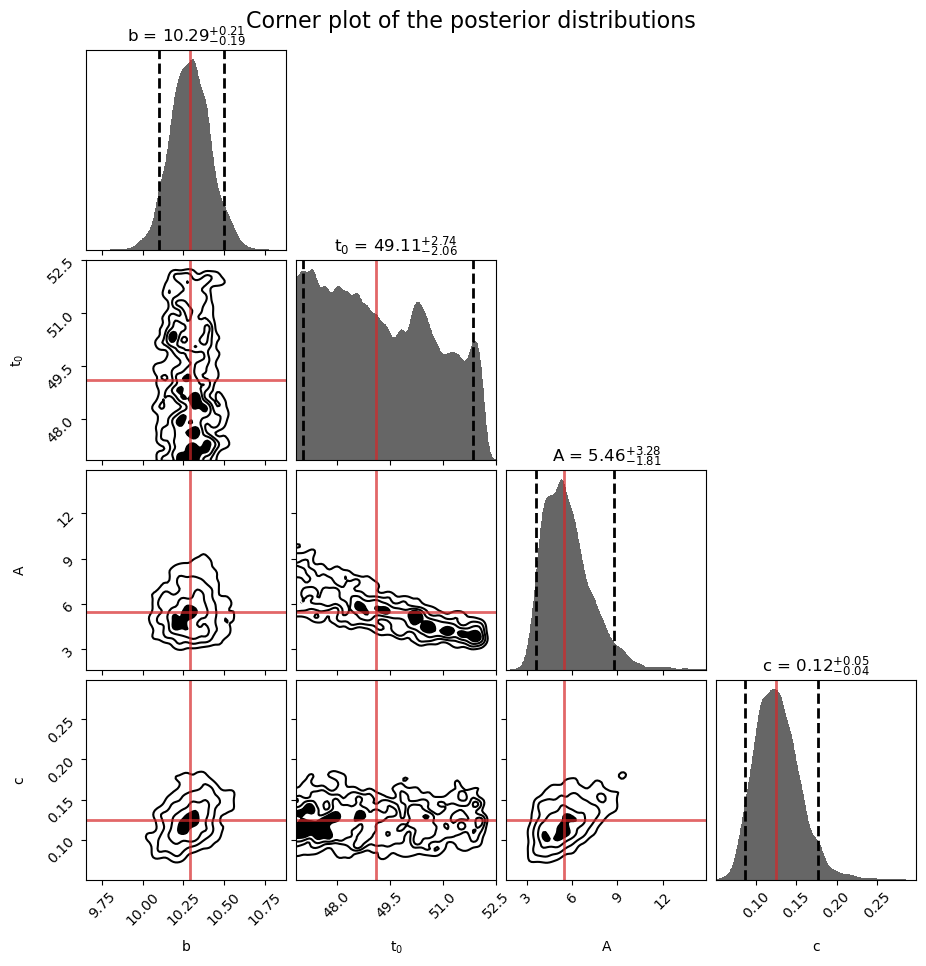

In [17]:
fig3, ax3 = dyplot.traceplot(results_burst, labels=labels_burst)
fig3.suptitle("Trace plot of the posterior distributions", fontsize=16, y=0.93)
fig3.subplots_adjust(hspace=0.3)

fig4, ax4 = dyplot.cornerplot(results_burst, labels=labels_burst, quantiles=(0.05, 0.95), 
                              show_titles=True, title_quantiles=(0.05, 0.5, 0.95), 
                              title_kwargs={"fontsize": 12}, 
                              truths=medians_burst, truth_color='tab:red')
fig4.suptitle("Corner plot of the posterior distributions", fontsize=16, y=1)

In [18]:
sampler_gauss = dynesty.NestedSampler(LogLikelihood, Prior_gauss, ndim, logl_args=[time, flux, sigma, model_gauss], nlive=300, sample='unif')
sampler_gauss.run_nested()
results_gauss = sampler_gauss.results

2923it [01:57, 24.81it/s, +300 | bound: 11 | nc: 1 | ncall: 15954 | eff(%): 20.589 | loglstar:   -inf < -144.361 <    inf | logz: -152.867 +/-  0.160 | dlogz:  0.001 >  0.309]


Weighted medians for gauss model [10.32483698 55.3714865   2.72521788  5.22358861]


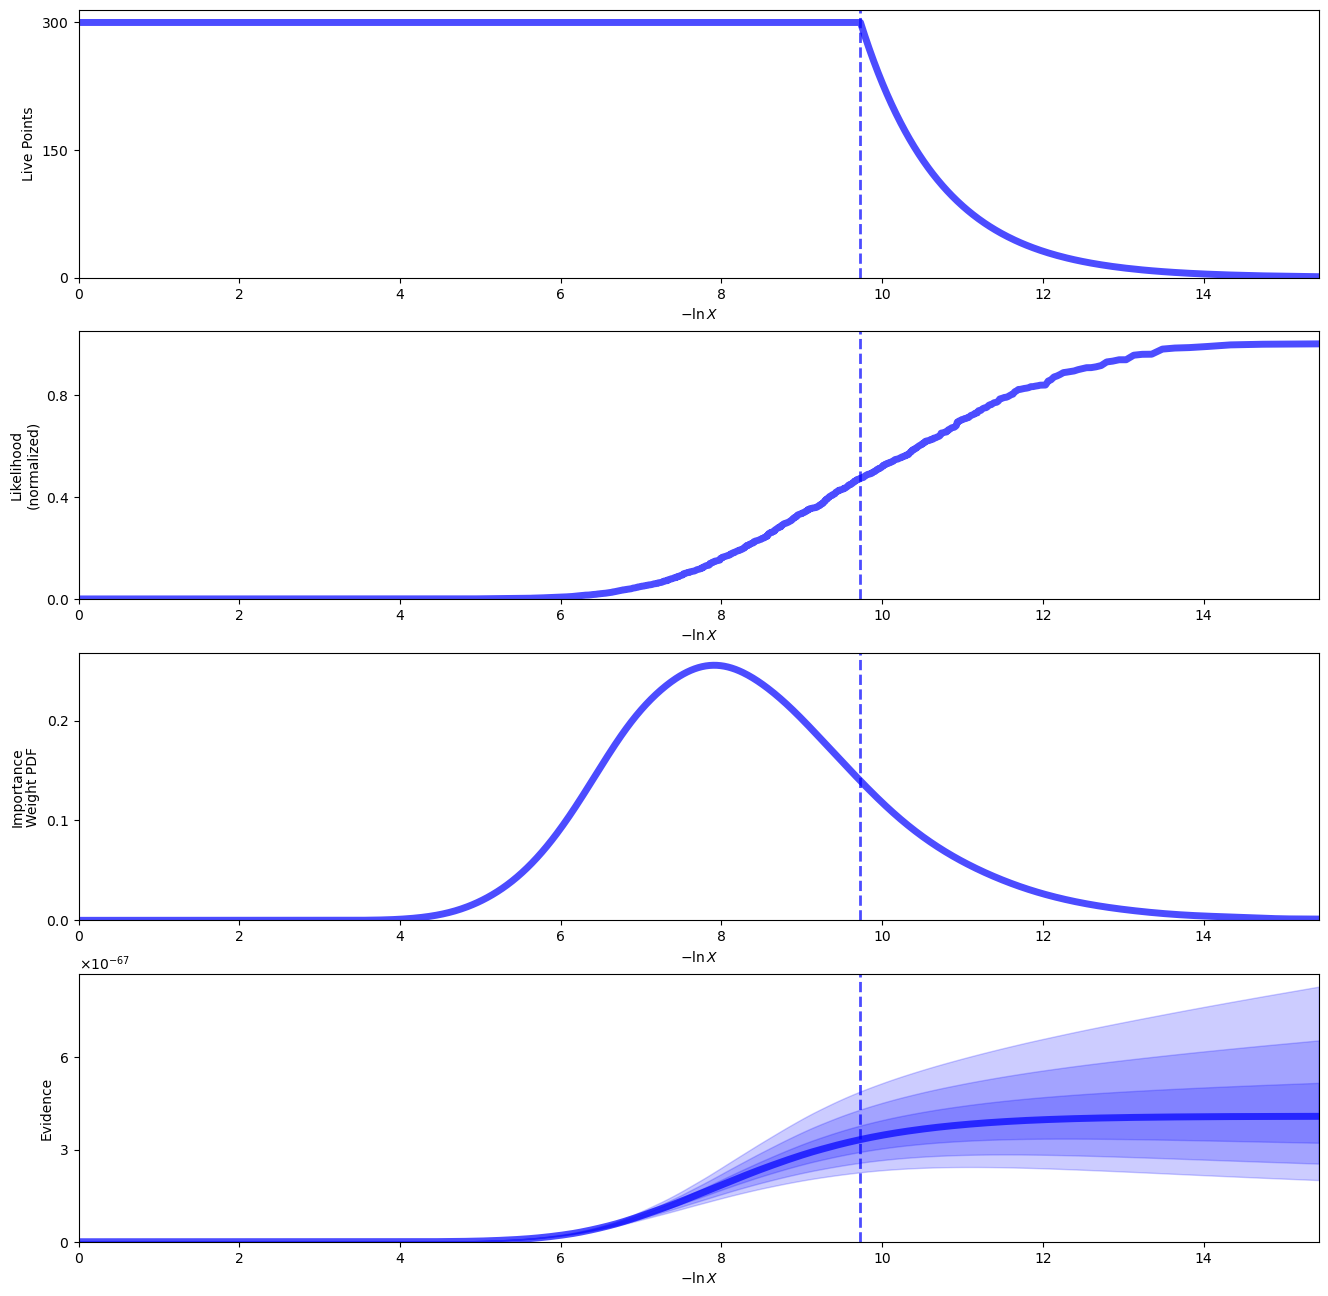

In [19]:
samples_gauss = results_gauss.samples  # samples
weights_gauss = np.exp(results_gauss.logwt - results_gauss.logz[-1])
medians_gauss = np.squeeze(np.array([dyfunc.quantile(x, [0.5], weights=weights_gauss) for x in samples_gauss.T]))
print("Weighted medians for gauss model", medians_gauss)

fig6, ax6 = dyplot.runplot(results_gauss)

Text(0.5, 1, 'Corner plot of the posterior distributions')

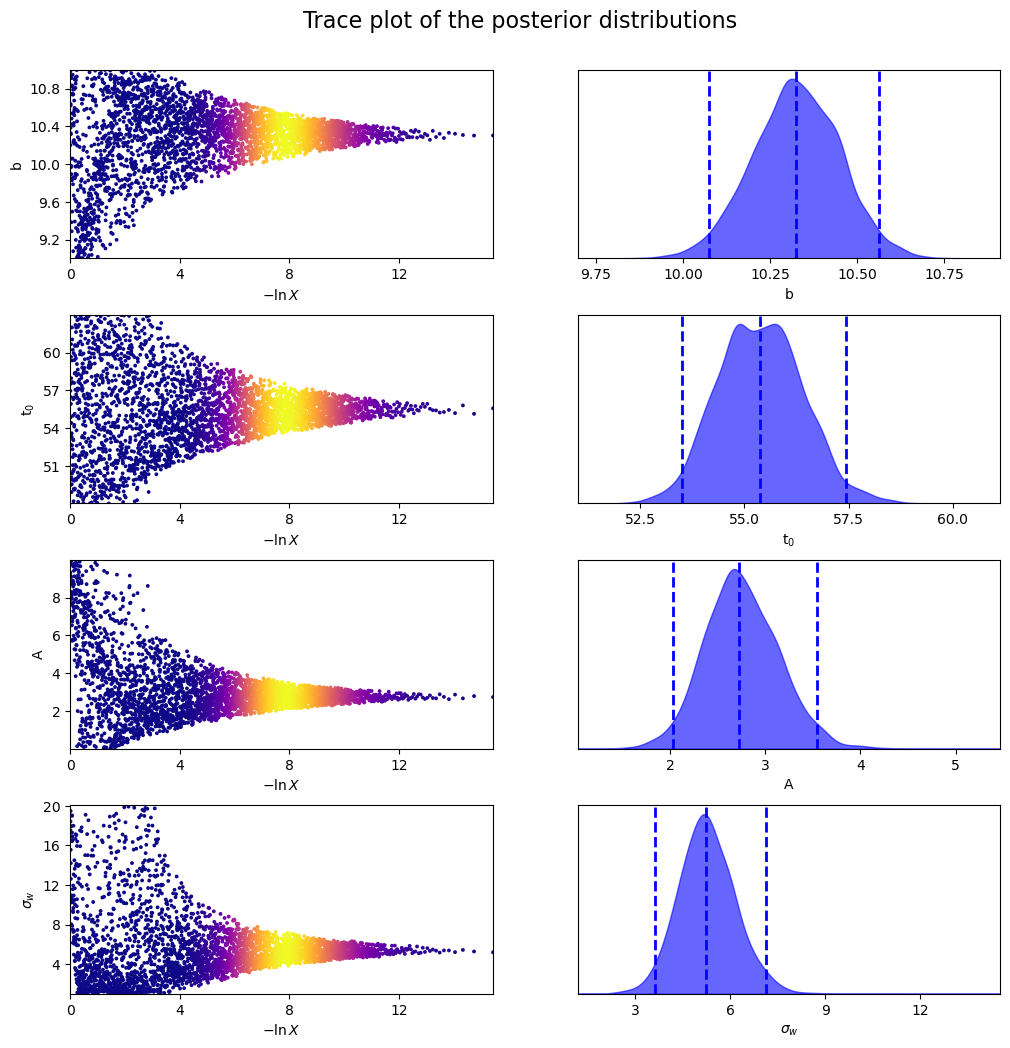

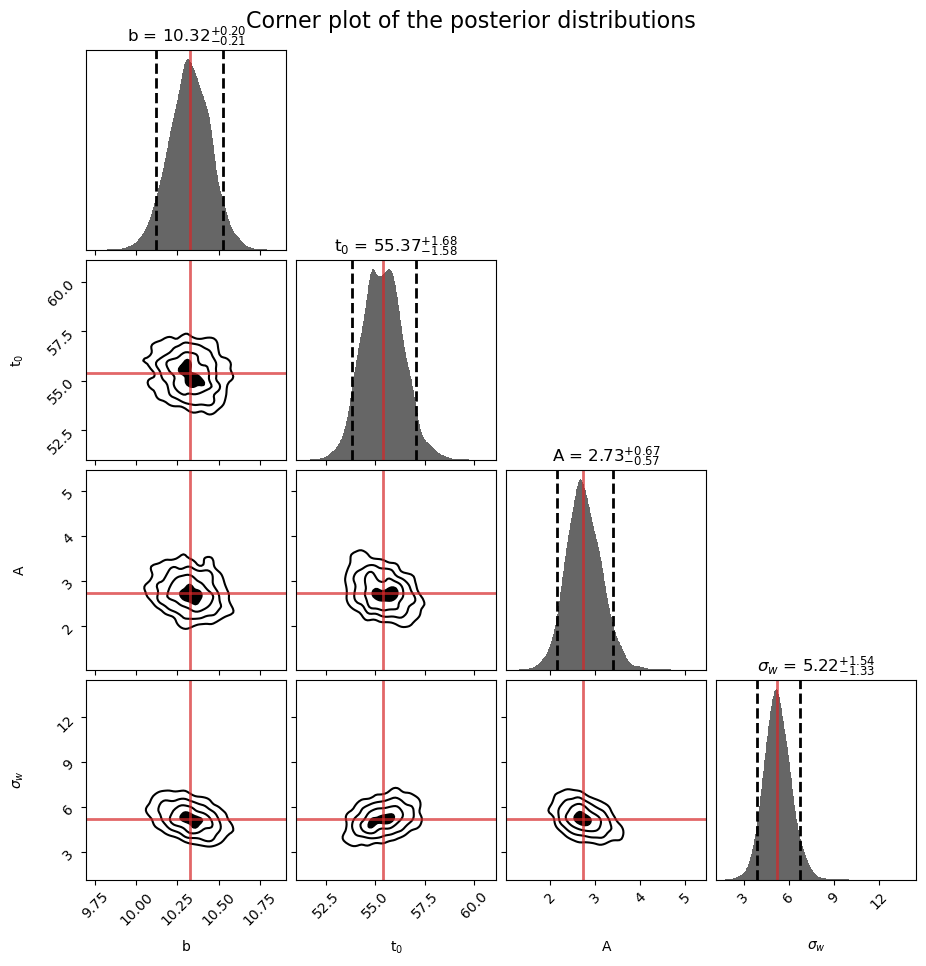

In [20]:
fig7, ax7 = dyplot.traceplot(results_gauss, labels=labels_gauss)
fig7.suptitle("Trace plot of the posterior distributions", fontsize=16, y=0.93)
fig7.subplots_adjust(hspace=0.3)

fig8, ax8 = dyplot.cornerplot(results_gauss, labels=labels_gauss, quantiles=(0.05, 0.95), 
                              show_titles=True, title_quantiles=(0.05, 0.5, 0.95), 
                              title_kwargs={"fontsize": 12}, 
                              truths=medians_gauss, truth_color='tab:red')
fig8.suptitle("Corner plot of the posterior distributions", fontsize=16, y=1)

In [21]:
evidence_burst = results_burst.logz[-1] #evidence for burst model
print("Bayesian evidence for burst model", np.exp(evidence_burst))

evidence_gauss = results_gauss.logz[-1] #evidence for gaussian model
print("Bayesian evidence for gauss model", np.exp(evidence_gauss))

print("Bayesian evidence ratio", np.exp(evidence_burst)/np.exp(evidence_gauss)) #ratio of evidences

Bayesian evidence for burst model 1.6070437011337582e-64
Bayesian evidence for gauss model 4.0821980834547435e-67
Bayesian evidence ratio 393.67117133466616
